In [1]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, measure, color, transform
import napari 
from src.translate_plugin import translate
from matplotlib_venn import venn2
import math
from skimage.measure import regionprops
import seaborn as sns
import matplotlib.patches as patches

Big-FISH version: 0.6.2


In [2]:
# def apply_segmentation_mask(clean_channel, translated_segm):
#     binary_mask = (translated_segm > 0).astype(int)
#     segm_mask_expand = np.expand_dims(binary_mask, axis=-3)

#     return clean_channel * segm_mask_expand

def detect_spots(channel, spot_radius_px, manual_threshold=None):
    
    # Local maximum detection
    mask = detection.local_maximum_detection(channel, min_distance=spot_radius_px)
    
    # If a manual threshold is provided, use it otherwise, use automated_threshold_setting
    if manual_threshold is not None:
        threshold = manual_threshold
    else:
        threshold = detection.automated_threshold_setting(channel, mask)
    
    # Thresholding
    spots, _ = detection.spots_thresholding(channel, mask, threshold)
    
    return spots.astype(np.uint16), threshold

# Input and FIX THE CHANNEL WITH DIC/SEGM CHANNEL OFFSET

In [3]:
# Load f channels and segm mask from cellpose GLU1,2 SUCR1,2 
image = io.imread('E:/microscopy/PP7BIGFISH/input/TIF/Sc_GLU2.tif')
flo11 = image[:,:,:,0]
flo8 = image[:,:,:,1]
pp7 = image[:,:,:,2]

segm = io.imread('E:/microscopy/PP7BIGFISH/input/segmentations/glu2mask.png', as_gray=True)

In [ ]:
#mask translation because of drift between dic and fluo channel
viewer = napari.Viewer()
# viewer.window.add_dock_widget(translate())
viewer.add_image(flo8, name='FLO8')
# viewer.add_image(pp7, name='PP7_unsliced')
# viewer.add_labels(segm, name='mask')

# #move the mask with AWDS and T to save the translated one

#  We LoG transform before we multiply with binary mask cause we need the surrounding information

In [4]:
spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=(200, 65, 65),  # in nanometer (one value per dimension zyx)
    object_radius_nm=(1000, 170, 170),  # each spot is 3x3  radius
    ndim=3)
print(spot_radius_px)

(4.0, 3.3846153846153846, 3.3846153846153846)


In [5]:
rna_log0 = stack.log_filter(flo11, sigma=spot_radius_px)
rna_log1 = stack.log_filter(flo8, sigma=spot_radius_px)
rna_log2= stack.log_filter(pp7, sigma=spot_radius_px)

In [6]:
#insert the shifted mask if we want to use segmentation
translated_segm = io.imread('E:/Scripts/Quantification/notebooks/translated_segm/shifted_maskglu2.tif')
#shifted_maskglu1,2 or sucr1,2

#viewer.add_image(translated_segm, name='clean_LoG_FLO8')


binary_mask = (translated_segm > 0).astype(int) # gives True for >0 false to <0 (boolean)
binary_mask = binary_mask.astype(np.uint8) # transform true to 1 and false to 0 

# # Expand the 2D segmentation mask to match the number of channels in the fluorescence channel if i want to  multipply
segm_mask_expand = np.expand_dims(binary_mask, axis=-3)

# Focus on clean layers visualy

In [7]:

# Define the clean slices range
start, end = 18, 60   #sucr2 23-60 sucr1, 24-60 sucr2, gluc 18-60

# in focus LoG channels 
clean_flo11 = rna_log0[start:end, :, :]
clean_flo8= rna_log1[start:end, :, :]
clean_pp7  = rna_log2[start:end, :, :]

# in focus non LoG channels
flo8_slice = flo8[start:end, :, :]
pp7_slice = pp7[start:end, :, :]
flo11_slice = flo11[start:end, :, :]


#  Apply translated segmentation mask of the dic to the flu log transformed channel  (ADD 1st FLO8 channel 2nd PP7) 

In [8]:
# Apply the segmentation mask to each channel of the fluorescence image or use the raw data depending if we have good segm

FLO11_segm = clean_flo11 * segm_mask_expand

PP7_segm = clean_pp7 * segm_mask_expand

FLO8_segm = clean_flo8  * segm_mask_expand

# SPOT detection

In [32]:
# FLO8
spots1, threshold1 = detect_spots(FLO8_segm, spot_radius_px,1) #thresholds  sucr2:5
spots1 = spots1.astype(np.int64)
print("detected flo8 spots")
print("\r shape: {0}".format(spots1.shape))
print("\r threshold: {0}".format(threshold1))
np.save('spots\processed_spots_1.npy', spots1) # change the name

detected flo8 spots

 shape: (1041, 3)

 threshold: 1


In [10]:
# PP7
spots2, threshold2 = detect_spots(PP7_segm, spot_radius_px,1) #thresholds  sucr2:5
spots2 = spots2.astype(np.int64)
print("detected pp7 spots")
print("\r shape: {0}".format(spots2.shape))
print("\r threshold: {0}".format(threshold2))
np.save('spots\processed_spots_2.npy', spots2)

detected pp7 spots

 shape: (1563, 3)

 threshold: 1


In [12]:
# FLO11
manual_threshold_value = 3  # Replace with your desired threshold value
spots0, threshold0 = detect_spots(FLO11_segm, spot_radius_px,0) #thresholds  sucr2:3
spots0 = spots0.astype(np.int64)
print("detected flo11 spots")
print("\r shape: {0}".format(spots0.shape))
print("\r threshold: {0}".format(threshold0))
np.save('spots\processed_spots_0.npy', spots0)

detected flo11 spots

 shape: (2798, 3)

 threshold: 0


# BAR implementation for spot detection thresholding ( need to minimise the threshold so we detect all spots and then start filtering)

In [30]:
viewer = napari.Viewer()
viewer.add_image(clean_flo8, name='FLO8')
viewer.add_image(clean_pp7, name='PP7')
viewer.add_points(spots1)
viewer.add_points(spots2)


<Points layer 'spots2' at 0x258236793f0>

In [31]:
from magicgui import magic_factory, magicgui
from napari.layers import Image, Points

@magicgui(auto_call=False, intensity_threshold={"widget_type": "Slider", 'max': 10})
def filter_spots(points: Points, intensity_image : Image, intensity_threshold: int,viewer: napari.Viewer):
    """filter all the spots based on RF class probability and intensity"""
    #(auto_call=False,probability_threshold={"widget_type": "Slider", 'max': 100}, intensity_threshold={"widget_type": "Slider", 'max': 65536}, focus_threshold={"widget_type": "Slider", 'max': 30})
#def filter_spots(points: Points, intensity_image : Image, intensity_threshold: int, probs_img: Image,probability_threshold : int, focus_img: Image,focus_threshold : int, viewer: napari.Viewer):
    #extract spots from layer
    spots = points.data 
    
    #filter spots
    filtered_spots = []
    for spot in spots:
        z,y,x = spot
        
        #probability = probs_img.data[z,y,x]
        intensity = intensity_image.data[z,y,x]
    
        if float(intensity) > float(intensity_threshold) : 
            
            filtered_spots.append([z,y,x])
            
    #add new points to viewer 
    viewer.add_points(filtered_spots, name='filtered_spots')
      
viewer.window.add_dock_widget(filter_spots)

C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1

C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1

C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1

C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1

C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1

C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1

C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\Thed\anaconda3\envs\FISH\lib\site-packages\napari\layers\base\base.py:1

# Testing different thresholds  : Always look on how they perform and if needed put a manual intensity threshold!!

In [ ]:
# viewer.add_points(spots1, face_color= 'red')
# viewer.add_points(spots2, face_color= 'blue')
# viewer.add_image(FLO8_segm, name = 'flo8')

In [ ]:
#  viewer.add_image(flo11_slice, name = 'flo11')
# viewer.add_image(FLO11_segm, name = 'flo11')
# viewer.add_points(spots0, face_color= 'green')

# Colocalisation threshold

In [12]:
def calculate_iou(spots__1, spots__2, colocalized):

    # Calculate intersection and union
    intersection = colocalized.shape[0]
    union = spots__1.shape[0] + spots__2.shape[0]

    # Calculate IoU
    #iou = intersection / union if union != 0 else 0.0
    iou = intersection / min(len(spots__1), len(spots__2))
    #max_iou = intersection / max(len(spots__1), len(spots__2))

    return iou 


In [13]:
# iou_values = []
# thresholds = []
# for threshold in range (0, 1000, 65):
    
#     (spots_1_colocalized, spots_2_colocalized, 
#      distances, 
#      indices_1, indices_2, 
#              threshold) = multistack.detect_spots_colocalization(
#                 spots_1=spots1,  # change only these 2 tsekarw plot me spots1_crop, spots2_crop
#                 spots_2=spots2,
#                 voxel_size=(200, 65, 65),
#                 threshold= threshold,
#                 return_indices=True,
#                 return_threshold=True)
           
#     iou = calculate_iou(spots1, spots2, spots_1_colocalized)
#     iou_values.append(iou)
#     thresholds.append(threshold)

# # Plotting
# plt.plot(thresholds, iou_values, marker='o')
# plt.xlabel('Threshold (nm)')
# plt.ylabel('IoU')
# plt.title('IoU-pp7-flo8 vs. Coloc Threshold ')
# plt.grid(True)
# plt.show()
# #TOTAL IOU BASED ON NUMBER OF SPOTS

In [14]:
# # Threshold for the highest iou : 
# last_max_iou_index = len(iou_values) - np.argmax(iou_values[::-1]) - 1
# last_max_threshold = thresholds[last_max_iou_index]
# print(last_max_threshold)

# Colocalisation of PP7 FLO8 

In [15]:
(spots_1_colocalized, spots_2_colocalized,
 distances, 
 indices_1, indices_2, 
 threshold) = multistack.detect_spots_colocalization(
    spots_1=spots1, 
    spots_2=spots2,
    threshold = 600, #600 gia glu2
    voxel_size=(200, 65, 65),
    return_indices=True,
    return_threshold=True)
print("colocalized spots")
print("\r shape 1: {0}".format(spots_1_colocalized.shape))
print("\r shape 2: {0}".format(spots_1_colocalized.shape))
print("\r distances: {0}".format(distances.shape))
print("\r indices 1: {0}".format(spots_1_colocalized.shape))
print("\r indices 2: {0}".format(spots_2_colocalized.shape))
print("\r threshold: {0:0.2f} nm".format(threshold))
#viewer.add_points(spots_1_colocalized)
#viewer.add_points(spots_2_colocalized)

colocalized spots

 shape 1: (6, 3)

 shape 2: (6, 3)

 distances: (6,)

 indices 1: (6, 3)

 indices 2: (6, 3)

 threshold: 600.00 nm


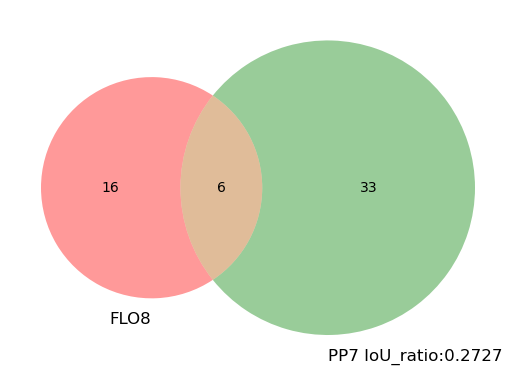

In [16]:
# Example data (replace these with your actual data)
set1_size = spots1.shape[0]
set2_size = spots2.shape[0]
colocalized_size = spots_1_colocalized.shape[0]
set1_size -= colocalized_size
set2_size -= colocalized_size
iou = calculate_iou(spots1, spots2, spots_1_colocalized)
# Create a Venn diagram
venn_labels = {'100': set1_size, '010': set2_size, '110': colocalized_size}

venn2(subsets=(set1_size, set2_size, colocalized_size), set_labels=('FLO8', f'PP7 IoU_ratio:{iou:.4f}'))

plt.show()

# # CROPS- show off performance

In [17]:
# # #max projection of flo8 LoG
# # rna_mip_flo8 = stack.maximum_projection(clean_flo8)
# # rna_mip_pp7 = stack.maximum_projection(clean_pp7)

# # #projection of fluorescence channel
# # rna_max_flo8 = stack.maximum_projection(flo8)
# # rna_max_pp7 = stack.maximum_projection(pp7)

# # Define the coordinates of the crop region
# y1, x1 = 916, 1005
# y2, x2 = 1111, 1317

# # Crop the images

# #LoGs and projections
# crop_flo8 = clean_flo8[:,y1:y2, x1:x2]
# #crop_flo8_mip = rna_mip_flo8[y1:y2, x1:x2]


# crop_pp7 = clean_pp7[:,y1:y2, x1:x2]
# #crop_pp7_mip = rna_mip_pp7[y1:y2, x1:x2]

# crop_og_flo8 = flo8_slice[:,y1:y2, x1:x2]
# crop_og_pp7 = pp7_slice[:,y1:y2, x1:x2]

In [18]:
# Flo8 crop

# spots_flo8_crop,_ = detect_spots(crop_flo8, spot_radius_px)

# # PP7
# spots_pp7_crop,_ = detect_spots(crop_pp7, spot_radius_px)

#flo11

#spots_flo11 = detect_spots(crop_flo11, spot_radius_px)

In [19]:
# viewer = napari.Viewer()
# viewer.add_image(crop_flo8, name = "flo8")
# viewer.add_image(crop_pp7, name = "pp7")
# viewer.add_points(spots_crop1, edge_color = "green", name = "flo8" )
# viewer.add_points(spots_crop2,opacity=1, edge_color = "magenta", name = "pp7")


In [20]:
# viewer.add_points(spots2_coloc_crop,opacity=1,  name = "colocpp7")
# viewer.add_points(spots1_coloc_crop,opacity=1,  name = "coloc2")

# viewer.add_points(spots_crop1, edge_color = "green", name = "flo8" )
# viewer.add_points(spots_crop2,opacity=1, edge_color = "magenta", name = "pp7")


# FLO8 Detection performance

In [21]:
# import matplotlib.patches as patches
# #num_layers = crop_flo8.shape[0]

# plt.figure(num='LoG',figsize=(20, 30))

# # Adjust the spacing between subplots
# plt.subplots_adjust(wspace=0.0, hspace=0.0)
# z=0
# for i in range(4): 
    
#     crop_layer = crop_flo8[i, :, :]
    
#     # Filter spots based on the current layer (z-coordinate)
#     layer_spots = [spot for spot in spots_flo8_crop if spot[0] == i]
    
#     if layer_spots:
#         # Unpack the coordinates for scatter plot
#         zs, ys, xs = zip(*layer_spots)
#     else:
#         zs, ys, xs = [], [], []  # Empty lists if no points in the current layer
    
#     # Plot
#     plt.subplot(1,4 , i+1)
#     plt.imshow(crop_layer, cmap='gray')  
    
#     # we want emptycircles
#     for z, y, x in zip(zs, ys, xs):
#         circle = patches.Circle((x, y), radius=5, edgecolor='red', facecolor='none', lw=2)
#         plt.gca().add_patch(circle)
        
#     plt.title(f"FLO8 LoG - Layer {i + 1}")
#     plt.axis('off')
#     z+=1
# plt.tight_layout()
# plt.savefig('output\LoGflo8_det.png', dpi = 300)
# plt.show()



# plt.figure(num='Flu',figsize=(20, 30))
# # Adjust the spacing between subplots
# plt.subplots_adjust(wspace=0.0, hspace=0.0)
# for i in range(4):  # Adjust the number of rows and columns
#     crop_layer = crop_og_flo8[i, :, :]
    
#     # Filter spots based on the current layer
#     layer_spots = [spot for spot in spots_flo8_crop if spot[0] == i]
    
#     if layer_spots:
#         zs, ys, xs = zip(*layer_spots)
#     else:
#         zs, ys, xs = [], [], []  # Empty lists if no points in the current layer
    
#     # Plot 
#     plt.subplot(1,4 , i + 1)
#     plt.imshow(crop_layer, cmap='gray', vmin=500, vmax=700)
    
#     # we want emptycircles
#     for z, y, x in zip(zs, ys, xs):
#         circle = patches.Circle((x, y), radius=5, edgecolor='red', facecolor='none', lw=2)
#         plt.gca().add_patch(circle)
     
    
#     plt.title(f"Layer {i + 1}")
#     plt.axis('off')
# plt.tight_layout()
# plt.savefig('output\Fluflo8_det.png', dpi = 300)
# plt.show()



# Multiple layer detection

In [22]:
# # define how many stacks you want to visualize 
# import matplotlib.patches as patches
# stacks = 12

In [23]:

# #num_layers = crop_flo8.shape[0]
# plt.figure(figsize=(20, 30))

# for i in range(stacks): 
    
#     crop_layer = crop_flo8[i, :, :]
    
#     # Filter spots based on the current layer (z-coordinate)
#     layer_spots = [spot for spot in spots_crop1 if spot[0] <= i]
    
#     if layer_spots:
#         # Unpack the coordinates for scatter plot
#         zs, ys, xs = zip(*layer_spots)
#     else:
#         zs, ys, xs = [], [], []  # Empty lists if no points in the current layer
    
#     # Plot
#     plt.subplot(3,4 , i+1)
#     plt.subplots_adjust(wspace=0.02, hspace=0.02, right=0.7)
#     plt.imshow(crop_layer, cmap='gray')  
    
#     for z, y, x in zip(zs, ys, xs):
#         # Set edgecolor based on the current layer
#         if i == z:
#             edgecolor= 'green' 
#         elif  i <= stacks:
#             edgecolor= 'purple' 
#         else:
#             edgecolor= 'black'
#         if edgecolor == 'purple':
#             alpha = 0.4
#         elif edgecolor== 'black':
#             alpha= 0
            
#         else:
#             alpha=1
#         circle = patches.Circle((x, y), radius=6, edgecolor=edgecolor, facecolor='none', lw=2, alpha=alpha)
#         plt.gca().add_patch(circle)
        
#     plt.title(f"FLO8 LoG - Layer {i + 1}")
#     plt.axis('off')
# plt.tight_layout()
# plt.savefig('output\lolflo8LoG_det.png', dpi = 300)
# plt.show()



# plt.figure(figsize=(20, 30))
# for i in range(stacks):  # Adjust the number of rows and columns
#     crop_layer = crop_norm_flo8[i, :, :]
    
#     # Filter spots based on the current layer (z-coordinate)
#     layer_spots = [spot for spot in spots_crop1 if spot[0] <= i]
    
#     if layer_spots:
#         # Unpack the coordinates for scatter plot
#         zs, ys, xs = zip(*layer_spots)
#     else:
#         zs, ys, xs = [], [], []  # Empty lists if no points in the current layer
    
#     # Plot
#     plt.subplot(3,4 , i+1)
#     plt.subplots_adjust(wspace=0.02, hspace=0.02, right=0.7)
#     plt.imshow(crop_layer, cmap='gray', vmin=500, vmax=700)
    
#     for z, y, x in zip(zs, ys, xs):
#         # Set edgecolor based on the current layer
#         if i == z:
#             edgecolor= 'green' 
#         elif  i <= stacks:
#             edgecolor= 'purple' 
#         else:
#             edgecolor= 'black'
#         if edgecolor == 'purple':
#             alpha = 0.4
#         elif edgecolor== 'black':
#             alpha= 0
            
#         else:
#             alpha=1
#         circle = patches.Circle((x, y), radius=6, edgecolor=edgecolor, facecolor='none', lw=2, alpha=alpha)
#         plt.gca().add_patch(circle)
     
    
#     plt.title(f"FLO8 Layer {i + 1}")
#     plt.axis('off')
# plt.tight_layout()

# plt.savefig('output\lolflo8Flu_det.png', dpi = 300)
# plt.show()



# FOR PP7 Green color

In [24]:
# plt.figure(figsize=(20, 30))
# for i in range(stacks):  # Adjust the number of rows and columns based on your preference
    
#     crop_layer = crop_pp7[i, :, :]
    
#     # Filter spots based on the current layer (z-coordinate)
#     layer_spots = [spot for spot in spots_crop2 if spot[0] <= i]
    
#     if layer_spots:
#         # Unpack the coordinates for scatter plot
#         zs, ys, xs = zip(*layer_spots)
#     else:
#         zs, ys, xs = [], [], []  # Empty lists if no points in the current layer
    
#     # Plot
#     plt.subplot(3,4 , i+1)
#     plt.subplots_adjust(wspace=0.02, hspace=0.02, right=0.7)
#     plt.imshow(crop_layer, cmap='gray')  
    
#     for z, y, x in zip(zs, ys, xs):
#         # Set edgecolor based on the current layer
#         if i == z:
#             edgecolor= 'green' 
#         elif  i <= stacks:
#             edgecolor= 'purple' 
#         else:
#             edgecolor= 'black'
#         if edgecolor == 'purple':
#             alpha = 0.4
#         elif edgecolor== 'black':
#             alpha= 0
            
#         else:
#             alpha=1
#         circle = patches.Circle((x, y), radius=6, edgecolor=edgecolor, facecolor='none', lw=2, alpha=alpha)
#         plt.gca().add_patch(circle)
        
#     plt.title(f"PP7 LoG - Layer {i + 1}")
#     plt.axis('off')
    
# plt.tight_layout()
# plt.savefig('output\lolpp7LoG_det.png', dpi = 300)
# plt.show()



# plt.figure(figsize=(20, 30))
# # Adjust the spacing between subplots

# for i in range(stacks):  # Adjust the number of rows and columns
#     crop_layer = crop_norm_pp7[i, :, :]
    
#     # Filter spots based on the current layer (z-coordinate)
#     layer_spots = [spot for spot in spots_crop2 if spot[0] <= i]
    
#     if layer_spots:
#         # Unpack the coordinates for scatter plot
#         zs, ys, xs = zip(*layer_spots)
#     else:
#         zs, ys, xs = [], [], []  # Empty lists if no points in the current layer
    
#     # Plot
#     plt.subplot(3,4 , i+1)
#     plt.subplots_adjust(wspace=0.02, hspace=0.02, right=0.7)
#     plt.imshow(crop_layer, cmap='gray', vmin=350, vmax=650) 
    
#     for z, y, x in zip(zs, ys, xs):
#         # Set edgecolor based on the current layer
#         if i == z:
#             edgecolor= 'green' 
#         elif  i <= stacks:
#             edgecolor= 'purple' 
#         else:
#             edgecolor= 'black'
#         if edgecolor == 'purple':
#             alpha = 0.4
#         elif edgecolor== 'black':
#             alpha= 0
            
#         else:
#             alpha=1
#         circle = patches.Circle((x, y), radius=6, edgecolor=edgecolor, facecolor='none', lw=2, alpha=alpha)
#         plt.gca().add_patch(circle)
     
    
#     plt.title(f"PP7 Layer {i + 1}")
#     plt.axis('off')
# plt.tight_layout()

# plt.savefig('output\lolpp7Flu_det.png', dpi = 300)
# plt.show()


#  PP7 detection performance

In [25]:
# # LOg pp7 channel
# plt.figure(num='LoG',figsize=(20, 30))

# # Adjust the spacing between subplots
# plt.subplots_adjust(wspace=0.0, hspace=0.0)
# z=0
# for i in range(4):  # Adjust the number of rows and columns based on your preference
    
#     crop_layer = crop_pp7[i, :, :]
    
#     # Filter spots based on the current layer (z-coordinate)
#     layer_spots = [spot for spot in spots_crop2 if spot[0] == i]
    
#     if layer_spots:
#         # Unpack the coordinates for scatter plot
#         zs, ys, xs = zip(*layer_spots)
#     else:
#         zs, ys, xs = [], [], []  # Empty lists if no points in the current layer
    
#     # Plot
#     plt.subplot(1,4 , i+1)
#     plt.imshow(crop_layer, cmap='gray')  
    
#     # we want emptycircles
#     for z, y, x in zip(zs, ys, xs):
#         circle = patches.Circle((x, y), radius=5, edgecolor='red', facecolor='none', lw=2)
#         plt.gca().add_patch(circle)
        
#     plt.title(f"PP7 LoG - Layer {i + 1}")
#     plt.axis('off')
#     z+=1
# plt.tight_layout()
# plt.savefig('output\LoGpp7_det.png', dpi = 300)
# plt.show()


# # FLu pp7 channel
# plt.figure(num='Flu',figsize=(20, 30))
# # Adjust the spacing between subplots
# plt.subplots_adjust(wspace=0.0, hspace=0.0)
# for i in range(4):  # Adjust the number of rows and columns
#     crop_layer = crop_norm_pp7[i, :, :]
    
#     # Filter spots based on the current layer
#     layer_spots = [spot for spot in spots_crop2 if spot[0] == i]
    
#     if layer_spots:
#         zs, ys, xs = zip(*layer_spots)
#     else:
#         zs, ys, xs = [], [], []  # Empty lists if no points in the current layer
    
#     # Plot 
#     plt.subplot(1,4 , i + 1)
#     plt.imshow(crop_layer, cmap='gray', vmin=300, vmax=700)
    
#     # we want emptycircles
#     for z, y, x in zip(zs, ys, xs):
#         circle = patches.Circle((x, y), radius=5, edgecolor='red', facecolor='none', lw=2)
#         plt.gca().add_patch(circle)
     
    
#     plt.title(f"Layer {i + 1}")
#     plt.axis('off')
# plt.tight_layout()
# plt.savefig('output\FluPP7_det.png', dpi = 300)
# plt.show()



# Coloc

In [26]:
# plt.figure(figsize=(20, 30))
# # Adjust the spacing between subplots
# plt.subplots_adjust(wspace=0.0, hspace=0.0)
# for i in range(1):  # Adjust the number of rows and columns
#     crop_layer = crop_flo8[i, :, :]
    
#     # Filter spots based on the current layer
#     layer_spots = [spot for spot in spots1_coloc_crop if spot[0] == i]
    
#     if layer_spots:
#         zs, ys, xs = zip(*layer_spots)
#     else:
#         zs, ys, xs = [], [], []  # Empty lists if no points in the current layer
    
#     # Plot 
#     plt.subplot(1,4 , i + 1)
#     plt.imshow(crop_layer, cmap='gray')
    
#     # we want emptycircles
#     for z, y, x in zip(zs, ys, xs):
#         circle = patches.Circle((x, y), radius=5, edgecolor='blue', facecolor='none', lw=2)
#         plt.gca().add_patch(circle)
     
    
#     plt.title(f"Coloc-FLO8-Layer {i + 1}")
#     plt.axis('off')
# plt.tight_layout()
# plt.savefig('output\coloc_FLO8_glu2.png', dpi = 300)
# plt.show()

# plt.figure(figsize=(20, 30))
# # Adjust the spacing between subplots
# plt.subplots_adjust(wspace=0.0, hspace=0.0)
# for i in range(1):  # Adjust the number of rows and columns
#     crop_layer = crop_pp7[i, :, :]
    
#     # Filter spots based on the current layer
#     layer_spots = [spot for spot in spots2_coloc_crop if spot[0] == i]
    
#     if layer_spots:
#         zs, ys, xs = zip(*layer_spots)
#     else:
#         zs, ys, xs = [], [], []  # Empty lists if no points in the current layer
    
#     # Plot 
#     plt.subplot(1,4 , i + 1)
#     plt.imshow(crop_layer, cmap='gray')
    
#     # we want emptycircles
#     for z, y, x in zip(zs, ys, xs):
#         circle = patches.Circle((x, y), radius=5, edgecolor='blue', facecolor='none', lw=2)
#         plt.gca().add_patch(circle)
     
    
#     plt.title(f"Coloc-PP7-Layer {i + 1}")
#     plt.axis('off')
# plt.tight_layout()
# plt.savefig('output\coloc_PP7_glu2.png', dpi = 300)
# plt.show()


# Analysis per cell

In [27]:
# Labeling and Individual Cell Analysis
labeled_cells = translated_segm

#  Regions (cells) are labeled with unique integer values, so with this method we extract cell properties(label, centroid etc.)
cell_props = regionprops(labeled_cells) 

In [28]:
# all_FLO8 =[]
# all_FLO11 = []
    
# for cell in cell_props:
        
#         print(cell.label)
#         cell_label = cell.label
#         cell_mask = (labeled_cells == cell_label).astype(np.uint8) * 255

#         FLO8_segm_ind = rna_log1 * cell_mask
#         FLO11_segm_ind = rna_log0 * cell_mask


#         # local maximum
#         mask_F11_ind = detection.local_maximum_detection(FLO11_segm_ind, min_distance=spot_radius_px)
#         mask_F8_ind = detection.local_maximum_detection(FLO8_segm_ind, min_distance=spot_radius_px)

#         # FLO8 detection-thresholding
#         threshold = detection.automated_threshold_setting(FLO8_segm_ind, mask_F8_ind)
#         spots_FLO8, _ = detection.spots_thresholding(FLO8_segm_ind, mask_F8_ind, threshold)

#         # FLO11 detection
#         threshold = detection.automated_threshold_setting(FLO11_segm_ind, mask_F11_ind)
#         spots_FLO11, _ = detection.spots_thresholding(FLO11_segm_ind, mask_F11_ind, threshold)

#         # append data for the current cell to the lists
#         all_FLO8.append(spots_FLO8.shape[0])
#         all_FLO11.append(spots_FLO11.shape[0])
        
        




# PLOT - mRna  distribution across cells

In [29]:
# bin_width = 1

# # histogram of counts- cells
# plt.hist([all_FLO8, all_FLO11], bins=np.arange(min(min(all_FLO8), min(all_FLO11)), max(max(all_FLO8), max(all_FLO11)) + bin_width, bin_width), align='left', rwidth=0.5, orientation='horizontal', color=['blue', 'red'], label=['FLO8', 'FLO11'])


# plt.xlabel('Number of Cells')
# plt.ylabel('mRNA Counts')
# plt.title('Distribution of mRNAs in Cells')

# plt.legend()

# plt.savefig("E:/Scripts/Quantification/notebooks/output/flo8-flo11_count_distrib_sucr.png")
# plt.show()

# Running Single cell analysis ( id for ech cell), without running the individual cell tracking but the one on the start for the whole image

In [30]:
# Extracting cell IDs and counts from flo8_indiv
flo8_counts = {}
for spot in spots1:
    cell_id = labeled_cells[spot[1], spot[2]]
    flo8_counts[cell_id] = flo8_counts.get(cell_id, 0) + 1

# Get the maximum cell ID from cell_props
max_cell_id = max([cell.label for cell in cell_props])

# Fill in counts for cells with no spots
for cell_id in range(1, max_cell_id + 1):
    if cell_id not in flo8_counts:
        flo8_counts[cell_id] = 0

# Sort the dictionary based on cell IDs
flo8_counts = dict(sorted(flo8_counts.items()))
# Exclude id = 0 because its the bg
flo8_counts = {k: v for k, v in flo8_counts.items() if k != 0}

flo8_counts = dict(sorted(flo8_counts.items()))
print(flo8_counts)

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 3, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 1, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 4, 47: 0, 48: 0, 49: 1, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 1, 73: 1, 74: 0, 75: 0, 76: 0, 77: 0, 78: 6, 79: 0, 80: 1, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 4, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0}


In [31]:
pp7_counts = {}
for spot in spots2:
    cell_id = labeled_cells[spot[1], spot[2]]
    pp7_counts[cell_id] = pp7_counts.get(cell_id, 0) + 1

# Get the maximum cell ID from cell_props
max_cell_id = max([cell.label for cell in cell_props])

# Fill in counts for cells with no spots
for cell_id in range(1, max_cell_id + 1):
    if cell_id not in pp7_counts:
        pp7_counts[cell_id] = 0

#Exclude id = 0, its the bg
pp7_counts = {k: v for k, v in pp7_counts.items() if k != 0}

pp7_counts = dict(sorted(pp7_counts.items()))
print(pp7_counts)

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 7, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 4, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 5, 47: 0, 48: 0, 49: 2, 50: 3, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 3, 73: 1, 74: 0, 75: 0, 76: 0, 77: 0, 78: 5, 79: 0, 80: 2, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 3, 87: 4, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0}


In [32]:
flo11_counts = {}


for spot in spots0:
    cell_id = labeled_cells[spot[1], spot[2]]
    flo11_counts[cell_id] = flo11_counts.get(cell_id, 0) + 1

# Get the maximum cell ID from cell_props
max_cell_id = max([cell.label for cell in cell_props])

# Fill in counts for cells with no spots
for cell_id in range(1, max_cell_id + 1):
    if cell_id not in flo11_counts:
        flo11_counts[cell_id] = 0
    # Exclude id = 0, its the counts  on bg
flo11_counts = {k: v for k, v in flo11_counts.items() if k != 0}

flo11_counts = dict(sorted(flo11_counts.items()))
print(flo11_counts)

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 1, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 2, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 1, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0}


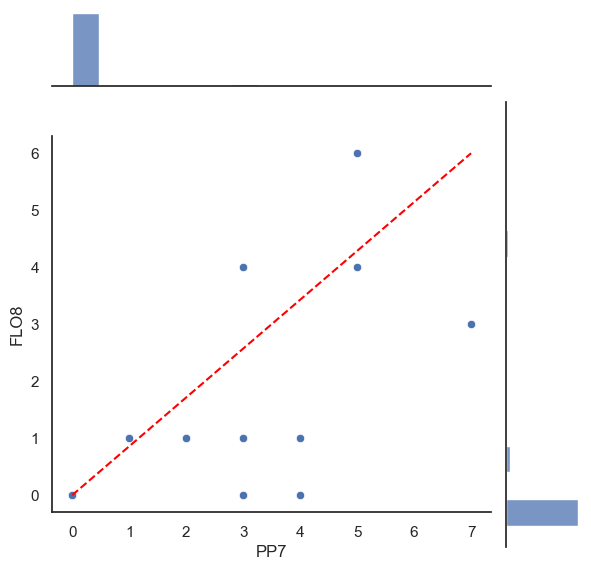

In [33]:


# Your existing code for ids and counts
ids = list(set(flo8_counts.keys()) & set(pp7_counts.keys()))
counts1 = [flo8_counts[id] for id in ids]
counts2 = [pp7_counts[id] for id in ids]

# Joint plot with seaborn
sns.set(style="white", color_codes=True)
joint_plot = sns.jointplot(x=counts2, y=counts1, kind="scatter", marginal_kws=dict(bins=15, fill=True), height=6)

# Draw the line of perfect X=Y
joint_plot.ax_joint.plot([min(counts2), max(counts2)], [min(counts1), max(counts1)], color='red', linestyle='--')




# Set aspect ratio to equal
joint_plot.ax_joint.set_aspect('equal')

plt.xlabel("PP7")
plt.ylabel("FLO8")

plt.show()





In [34]:
max(pp7_counts)

92

In [35]:
filaments =flo8_counts[41]
print(filaments)

0


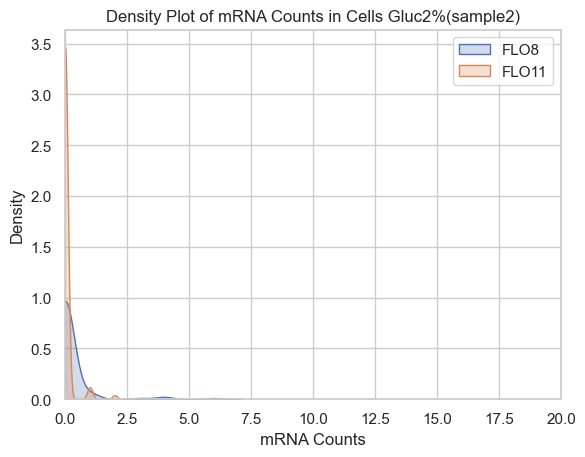

In [36]:

import pandas as pd

from matplotlib.ticker import MultipleLocator
# ftiaxnw bar plot historgram me percentage of cells sto y kai number of rna 
sns.set(style="whitegrid")

# Create density plots for FLO8 and FLO11 separately
sns.kdeplot(flo8_counts, fill=True, label='FLO8')
sns.kdeplot(flo11_counts, fill=True, label='FLO11')

plt.xlabel('mRNA Counts')
plt.ylabel('Density')
plt.title('Density Plot of mRNA Counts in Cells Gluc2%(sample2)')###!! change the title based on sample

plt.xlim(0, 20)


plt.legend()
plt.xlim(0, 20)
plt.show()


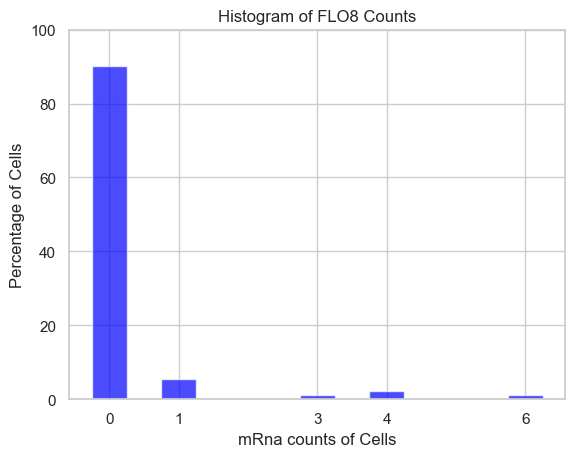

In [37]:
import matplotlib.pyplot as plt

# Given dictionary


# Count the occurrences of each value
value_counts = {}
for count in flo8_counts.values():
    value_counts[count] = value_counts.get(count, 0) + 1

# Calculate percentages based on the total number of counts
total_counts = sum(value_counts.values())
percentages = [count / total_counts * 100 for count in value_counts.values()]

# Plot the histogram
plt.bar(value_counts.keys(), percentages, color='blue', alpha=0.7, width=0.5, align='center')

# Set labels and title
plt.xlabel('mRna counts of Cells')
plt.ylabel('Percentage of Cells')
plt.title('Histogram of FLO8 Counts')
plt.ylim(0, 100)
# Set x-axis ticks to be integers
plt.xticks(list(value_counts.keys()))

# Show the plot
plt.show()

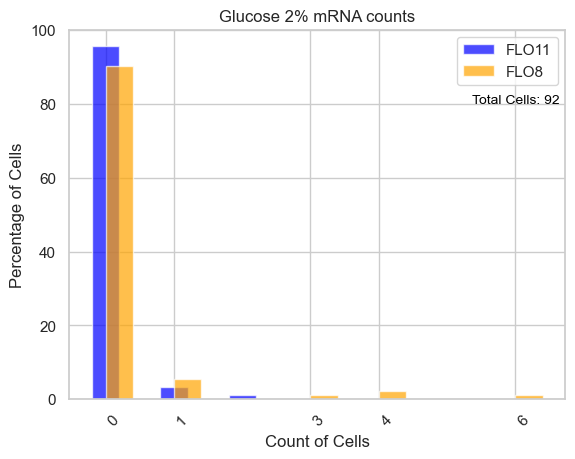

In [38]:

# Count the occurrences of each value for both dictionaries
value_counts1 = {}
for count in flo11_counts.values():
    value_counts1[count] = value_counts1.get(count, 0) + 1

value_counts2 = {}
for count in flo8_counts.values():
    value_counts2[count] = value_counts2.get(count, 0) + 1

# Calculate percentages based on the total number of counts for both dictionaries
total_counts1 = sum(value_counts1.values())
percentages1 = [count / total_counts1 * 100 for count in value_counts1.values()]

total_counts2 = sum(value_counts2.values())
percentages2 = [count / total_counts2 * 100 for count in value_counts2.values()]

# Plot the histograms
plt.bar(list(value_counts1.keys()), percentages1, color='blue', alpha=0.7, width=0.4, align='center', label='FLO11')
plt.bar(list(value_counts2.keys()), percentages2, color='orange', alpha=0.7, width=0.4, align='edge', label='FLO8')

# Set labels and title
plt.xlabel('Count of Cells')
plt.ylabel('Percentage of Cells')
plt.title('Glucose 2% mRNA counts')
total_cells_annotation = f'Total Cells: {total_counts1}'
plt.annotate(total_cells_annotation, xy=(0.9, 0.80), xycoords='axes fraction', ha='center', fontsize=10, color='black')

# enter the larger value counts for the plot numbers
plt.xticks(list(value_counts2.keys()))
# Rotate x-axis labels
plt.xticks(rotation=45, ha='left')

# Set y-axis range from 0 to 100
plt.ylim(0, 100)

# Show legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
ss